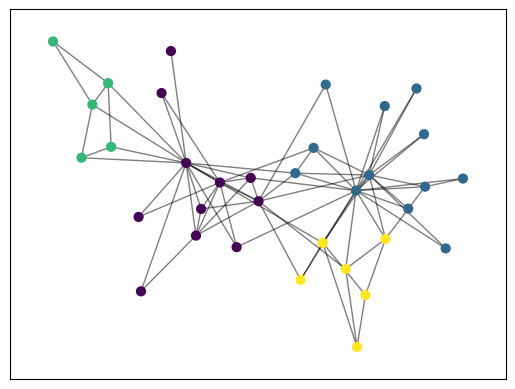

In [4]:
# display a graph with its communities:
# as Erdos-Renyi graphs don't have true community structure,
# instead load the karate club graph
import community_louvain
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
G = nx.karate_club_graph()
# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = matplotlib.colormaps.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

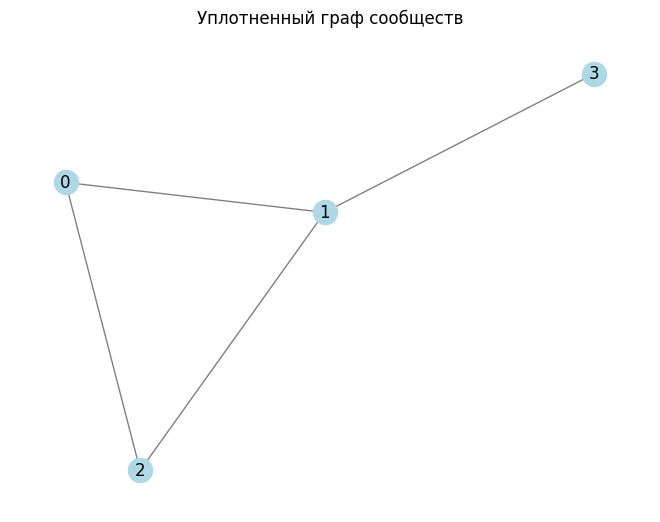

In [8]:
# Создание нового графа для уплотненных узлов
community_graph = nx.Graph()

# Добавление узлов в новый граф
for node in partition:
    community = partition[node]
    community_graph.add_node(community)  # Добавляем узел для сообщества, если он еще не добавлен

# Добавление рёбер в новый граф
for edge in G.edges():
    node1, node2 = edge
    community1 = partition[node1]
    community2 = partition[node2]
    if community1 != community2:  # Добавляем ребро между узлами, если они принадлежат разным сообществам
        community_graph.add_edge(community1, community2)

# Визуализация уплотненного графа
pos = nx.spring_layout(community_graph)  # Позиции узлов для всех узлов
nx.draw(community_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Уплотненный граф сообществ')
plt.show()

In [13]:
import networkx as nx

# Создаем пример графа с метриками узлов и ребер
def create_graph():
    G = nx.Graph()
    
    # Добавляем узлы с атрибутом производительности
    G.add_node(1, performance=10)
    G.add_node(2, performance=15)
    G.add_node(3, performance=20)
    G.add_node(4, performance=25)
    
    # Добавляем ребра с атрибутами латентности и пропускной способности
    G.add_edge(1, 2, latency=5, capacity=100, reliability=0.99)
    G.add_edge(2, 3, latency=3, capacity=150, reliability=0.98)
    G.add_edge(3, 4, latency=4, capacity=120, reliability=0.97)
    G.add_edge(4, 1, latency=2, capacity=110, reliability=0.96)
    
    return G

# Функция для выполнения кластеризации с помощью метода Лувена
def apply_louvain_clustering(G):
    # Словарь для кластеров
    partition = community_louvain.best_partition(G, weight='capacity')
    return partition

# Функция для пересчета метрик после кластеризации
def recalculate_metrics(G, partition):
    # Подготовим структуры данных для метрик
    cluster_performance = {}
    cluster_latency = {}
    cluster_capacity = {}
    cluster_reliability = {}

    # Инициализируем метрики для каждого кластера
    for node in G.nodes():
        cluster = partition[node]
        if cluster not in cluster_performance:
            cluster_performance[cluster] = 0
            cluster_latency[cluster] = 0
            cluster_capacity[cluster] = float('inf')
            cluster_reliability[cluster] = 1

        # Суммируем производительность
        cluster_performance[cluster] += G.nodes[node]['performance']

        # Для каждого ребра учитываем метрики
        for neighbor in G[node]:
            if partition[neighbor] == cluster:  # Учитываем ребра внутри кластера
                edge_data = G[node][neighbor]
                cluster_latency[cluster] += edge_data['latency']
                cluster_capacity[cluster] = min(cluster_capacity[cluster], edge_data['capacity'])
                cluster_reliability[cluster] *= edge_data['reliability']  # Простое произведение для примера

    return {
        'performance': cluster_performance,
        'latency': cluster_latency,
        'capacity': cluster_capacity,
        'reliability': cluster_reliability
    }

# Создаем граф
G = create_graph()

# Применяем алгоритм Лувена
partition = apply_louvain_clustering(G)

# Пересчитываем метрики
metrics = recalculate_metrics(G, partition)

# Выводим результаты для проверки
print(metrics)



{'performance': {1: 35, 0: 35}, 'latency': {1: 4, 0: 6}, 'capacity': {1: 110, 0: 150}, 'reliability': {1: 0.9216, 0: 0.9603999999999999}}


In [5]:
import ipywidgets as widgets
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt

def create_graph():
    G = nx.Graph()
    
    # Добавляем узлы с атрибутом производительности
    G.add_node(1, performance=10)
    G.add_node(2, performance=15)
    G.add_node(3, performance=20)
    G.add_node(4, performance=25)
    
    # Добавляем ребра с атрибутами латентности и пропускной способности
    G.add_edge(1, 2, latency=5, capacity=100, reliability=0.99)
    G.add_edge(2, 3, latency=3, capacity=150, reliability=0.98)
    G.add_edge(3, 4, latency=4, capacity=120, reliability=0.97)
    G.add_edge(4, 1, latency=2, capacity=110, reliability=0.96)
    
    return G

def draw_graph(G, partition):
    # Функция для отрисовки графа с учетом кластеров
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    colors = [partition[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=colors, with_labels=True, cmap=cmap)
    plt.show()

def update_clustering(depth):
    G = create_graph()
    # Настройка метода Лувена для изменения глубины кластеризации, может быть параметр resolution
    partition = community_louvain.best_partition(G, resolution=depth)
    draw_graph(G, partition)

slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='Clustering Depth:')
widgets.interactive(update_clustering, depth=slider)

interactive(children=(IntSlider(value=1, description='Clustering Depth:', max=10), Output()), _dom_classes=('w…

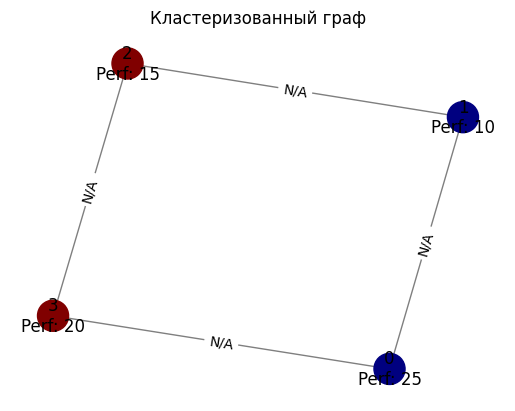

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_clustered_graph(G, partition, title="Кластеризованный граф"):
    # Создаем карту цветов для каждого сообщества
    color_map = {com: i for i, com in enumerate(set(partition.values()))}
    
    # Настройки цветов для узлов
    node_colors = [color_map[partition[node]] for node in G.nodes()]
    
    # Позиции узлов для красивой визуализации
    pos = nx.spring_layout(G)
    
    # Визуализация узлов
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, cmap=plt.cm.jet)
    
    # Визуализация рёбер
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # Метки узлов (например, можно выводить производительность или другие метрики)
    labels = {node: f"{node}\nPerf: {G.nodes[node].get('performance', 'N/A')}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    # Метки рёбер (можно выводить вес или другие атрибуты)
    edge_labels = {(u, v): f"{data.get('weight', 'N/A')}" for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title(title)
    plt.axis('off')  # Выключаем отображение осей
    plt.show()

# Пример использования функции
G = nx.Graph()
# Добавляем узлы с атрибутом производительности
G.add_node(1, performance=10)
G.add_node(2, performance=15)
G.add_node(3, performance=20)
G.add_node(0, performance=25)

# Добавляем ребра с атрибутами латентности и пропускной способности
G.add_edge(1, 2, latency=5, capacity=100, reliability=0.99)
G.add_edge(2, 3, latency=3, capacity=150, reliability=0.98)
G.add_edge(3, 0, latency=4, capacity=120, reliability=0.97)
G.add_edge(0, 1, latency=2, capacity=110, reliability=0.96)
partition = {0: 0, 1: 0, 2: 1, 3: 1}  # Пример разбиения на сообщества

draw_clustered_graph(G, partition)


In [10]:
from pyvis.network import Network
import networkx as nx
from IPython.core.display import display, HTML

def draw_interactive_graph(G, partition):
    net = Network(notebook=True, height="750px", width="100%")
    # Добавляем узлы и рёбра как раньше
    for node, node_attrs in G.nodes(data=True):
        net.add_node(node, label=str(node), title='\n'.join([f"{key}: {value}" for key, value in node_attrs.items()]), color=['red', 'blue'][partition[node]])

    for source, target, edge_attrs in G.edges(data=True):
        label = ', '.join([f"{key}: {value}" for key, value in edge_attrs.items()])
        net.add_edge(source, target, title=label)
    
    # Настройки визуализации
    net.set_options("""
    var options = {
      "nodes": {
        "font": {
          "size": 12
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": false
      },
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -26,
          "centralGravity": 0.005,
          "springLength": 230,
          "springConstant": 0.18
        },
        "maxVelocity": 146,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "enabled": true,
          "iterations": 1000,
          "updateInterval": 25,
          "onlyDynamicEdges": false,
          "fit": true
        }
      }
    }
    """)
    
    # Отображаем граф
    net.show("graph.html")
    return HTML("<iframe src='graph.html' width='100%' height='750px'></iframe>")


# Создание графа
G = nx.Graph()
G.add_edge(0, 1, weight=1, latency=5, capacity=100)
G.add_edge(1, 2, weight=2, latency=3, capacity=150)
G.add_edge(2, 3, weight=3, latency=4, capacity=120)
G.add_edge(3, 0, weight=4, latency=2, capacity=110)
G.add_node(0, performance=100)
G.add_node(1, performance=150)
G.add_node(2, performance=200)
G.add_node(3, performance=250)
partition = {0: 0, 1: 0, 2: 1, 3: 1}

display(draw_interactive_graph(G, partition))
# draw_interactive_graph(G, partition)


graph.html


C:\Users\igore\AppData\Local\Temp\ipykernel_7676\4050032100.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
C:\Users\igore\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [26]:
import networkx as nx
from pyvis.network import Network
import ipywidgets as widgets
from IPython.display import display, IFrame
import random
import community_louvain
from collections import defaultdict

# Функция для создания графа
def create_graph():
    G = nx.Graph()
    for i in range(100):
        G.add_node(i, performance=random.randint(50, 200))
    
    # Добавляем ребра с метриками
    for i in range(100):
        for j in range(i + 1, 100):
            if random.random() < 0.05:  # Плотность ребер ~5%
                weight = random.randint(1, 10)
                latency = random.randint(1, 10)
                capacity = random.randint(100, 1000)
                G.add_edge(i, j, weight=weight, latency=latency, capacity=capacity)

    return G

# Функция для визуализации кластеризованного графа

# def visualize_clusters(G, level):
#     net = Network(notebook=True, height="750px", width="100%")
#     partition = community_louvain.best_partition(G, resolution=level)
    
#     # Группируем узлы по сообществам
#     community_map = defaultdict(list)
#     for node, community_id in partition.items():
#         community_map[community_id].append(node)
    
#     simplified_graph = nx.Graph()
#     for community_id, nodes in community_map.items():
#         simplified_graph.add_node(f"Community {community_id + 1}", size=len(nodes)*1.1)
def visualize_clusters(G, level):
    net = Network(notebook=True, height="750px", width="100%")
    partition = community_louvain.best_partition(G, resolution=level)
    
    # Создаем узлы для каждого сообщества
    community_map = defaultdict(list)
    for node, community_id in partition.items():
        community_map[community_id].append(node)

    # Добавляем узлы в pyvis сеть
    for community_id, nodes in community_map.items():
        # Суммируем производительность узлов в каждом сообществе
        total_performance = sum(G.nodes[node]['performance'] for node in nodes)
        # Считаем среднюю производительность для подсказки
        avg_performance = total_performance / len(nodes)
        net.add_node(f"Community {community_id + 1}",
                     title=f"Community {community_id + 1} (Size: {len(nodes)}, Avg Performance: {avg_performance}, Total Performance: {total_performance})", 
                     size=20)  # Фиксированный размер узлов

    
    # # Добавляем узлы в pyvis сеть
    # for community_id, nodes in community_map.items():
    #     net.add_node(f"Community {community_id + 1}",
    #                  title=f"Community {community_id + 1} (Size: {len(nodes)})",
    #                  size=len(nodes)*1.1)  # Фиксированный размер узлов

    # Добавляем рёбра в pyvis сеть с масштабированием веса
    max_weight = 1
    edge_attributes = defaultdict(lambda: {'weight': 0, 'latency': [], 'capacity': []})
    for com1, nodes1 in community_map.items():
        for com2, nodes2 in community_map.items():
            if com1 < com2:
                for u in nodes1:
                    for v in nodes2:
                        if G.has_edge(u, v):
                            edge_data = G[u][v]
                            edge_attributes[(com1, com2)]['weight'] += edge_data['weight']
                            edge_attributes[(com1, com2)]['latency'].append(edge_data['latency'])
                            edge_attributes[(com1, com2)]['capacity'].append(edge_data['capacity'])
                            if edge_attributes[(com1, com2)]['weight'] > max_weight:
                                max_weight = edge_attributes[(com1, com2)]['weight']

    scale_factor = 10 / max_weight
    for (com1, com2), attrs in edge_attributes.items():
        scaled_weight = attrs['weight'] * scale_factor
        avg_latency = sum(attrs['latency']) / len(attrs['latency'])
        min_capacity = min(attrs['capacity'])
        net.add_edge(f"Community {com1 + 1}", f"Community {com2 + 1}", value=min_capacity,
                     title=f"Weight: {attrs['weight']}, Latency: {avg_latency}, Capacity: {min_capacity}")

    # Настройки визуализации
    net.set_options("""
    var options = {
      "nodes": {
        "font": {
          "size": 12
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": false
      },
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -26,
          "centralGravity": 0.005,
          "springLength": 230,
          "springConstant": 0.18
        },
        "maxVelocity": 146,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "enabled": true,
          "iterations": 1000,
          "updateInterval": 25,
          "onlyDynamicEdges": false,
          "fit": true
        }
      }
    }
    """)

    net.show("simplified_graph.html")
    return IFrame("simplified_graph.html", width="100%", height="750px")


# Граф для работы
G = create_graph()

# Интерактивный слайдер для выбора глубины кластеризации
slider = widgets.FloatSlider(
    value=1.0,
    min=0.,
    max=10000.0,
    step=0.1,
    description='Кластеризация:',
    continuous_update=False
)

# Обновление визуализации в зависимости от значения слайдера
def update_visualization(depth):
    display(visualize_clusters(G, depth))

# slider.observe(update_visualization, names='value')
# display(slider)
widgets.interactive(update_visualization, depth=slider)


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Кластеризация:', max=10000.…